In [6]:
%matplotlib inline
%load_ext jupyternotify
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
from fair_policies import * 
from xauc import * 

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
XTY_locs = [ 'data/crepon/X_pub_c.csv', 'data/crepon/T_pub_c.csv', 'data/crepon/Y_pub_c.csv','data/crepon/A_french.csv', 'data/crepon/grf_pred_crepon.csv'  ]
[X,T,Y,A,tau_hat,f_1pred,f_0pred, fdelta] = read_data( XTY_locs )

7950
7950


Sample splitting: CATE trained on one half of the data




In [21]:
N_REPS = 50
eta_ = 0.02;upper_fdelta = eta_*np.ones(len(A))
n_perc = 100; n_etas = 5
etas = np.geomspace(0.0005, 0.02, n_etas)


A_french = pd.read_csv('data/crepon/A_french.csv', header=None).values.flatten()
A_woman = pd.read_csv('data/crepon/A_woman.csv', header=None).values.flatten()
A_age = pd.read_csv('data/crepon/A_age.csv', header=None).values.flatten()


A_ = A_french 
SAMPLE_FN = 'data/crepon/reps/sample'
DATA_FN = 'data/crepon/reps/grf-pred-crepon'

def get_for_roc_from_sample( cate_pctiles, etas, A_, N_REPS, SAMPLE_FN, DATA_FN ): 
    indss = [ None ] * N_REPS
    cate_ests = [ None ] * N_REPS; cate_otherway = [ None ] * N_REPS
    n_perc = len(cate_pctiles)
    disps_nom_tprs = np.zeros([n_perc,N_REPS]); disps_nom_tnrs = np.zeros([n_perc,N_REPS]);
    lowers = np.zeros([n_perc, n_etas, N_REPS]); uppers = np.zeros([n_perc, n_etas, N_REPS])
    tnr_lowers = np.zeros([n_perc, n_etas, N_REPS]); tnr_uppers = np.zeros([n_perc, n_etas, N_REPS])

    for rep in range(N_REPS): 
        if rep % 10 == 0: 
            print rep
        indss[rep] = pd.read_csv(SAMPLE_FN+str(rep+1)+'.csv') - 1 # swap from R indexing ! 
        sample = np.zeros(len(A_)).astype(bool)
        sample[indss[rep]] = True
        # trained on [sample], oos preds on [-sample]
        cate_ests[rep] = np.clip(pd.read_csv(DATA_FN+str(rep+1)+'.csv').values,0,1).flatten()
#         if rep == 0: 
#             cate_pctiles = np.percentile(cate_ests[rep], np.linspace(0,100, n_perc))
        # trained on [-sample], oos preds on [sample]
        cate_otherway[rep] =  np.clip(pd.read_csv(DATA_FN+str(rep+1)+'.csv').values,0,1).flatten()

        # cate estimate is out of sample 
        [res_lower_, res_upper_] = get_disp_curve_over_etas(cate_ests[rep], n_perc, etas, A_[~sample], cate_ests[rep], 
              plotting=False, disparity = tpr_closed_form, parallel = "closed_form",
              fix_pctiles = True, fixed_pctiles = cate_pctiles)
        lowers[:,:,rep] = res_lower_; uppers[:,:,rep] = res_upper_ 

        [res_lower_tnr, res_upper_tnr] = get_disp_curve_over_etas(cate_ests[rep], n_perc, etas, A_[~sample], cate_ests[rep], 
          plotting=False, disparity = tnr_closed_form, parallel = "closed_form",
          fix_pctiles = True, fixed_pctiles = cate_pctiles)
        tnr_lowers[:,:,rep] = res_lower_tnr; tnr_uppers[:,:,rep] = res_upper_tnr 
        # get nominal tprs and tnrs 
        tprs_ = np.asarray([ tpr_estimation_delta((cate_ests[rep] >= cfpctile), cate_ests[rep], A_[~sample]) for cfpctile in cate_pctiles ]).reshape([len(cate_pctiles), 2])
        tnrs_ = np.asarray([ tnr_estimation_delta((cate_ests[rep] >= cfpctile), cate_ests[rep], A_[~sample]) for cfpctile in cate_pctiles ]).reshape([len(cate_pctiles), 2])
        disps_nom_tprs[:,rep] = tprs_[:,0] - tprs_[:,1]; disps_nom_tnrs[:,rep] = tnrs_[:,0] - tnrs_[:,1]
    return [ lowers, uppers, tnr_lowers, tnr_uppers, disps_nom_tprs, disps_nom_tnrs, cate_pctiles ]

cate_pctiles = np.percentile(np.clip(tau_hat,0,1), np.linspace(0,100, n_perc))




In [22]:
[ lowers, uppers, tnr_lowers, tnr_uppers, disps_nom_tprs, disps_nom_tnrs, cate_pctiles ] = get_for_roc_from_sample( cate_pctiles, etas, A_, N_REPS, SAMPLE_FN, DATA_FN )

0
10
20
30
40


<Figure size 432x288 with 0 Axes>

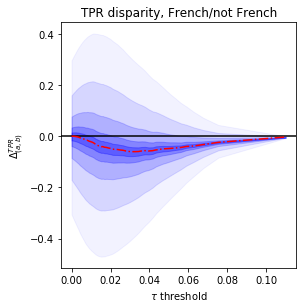

<Figure size 432x288 with 0 Axes>

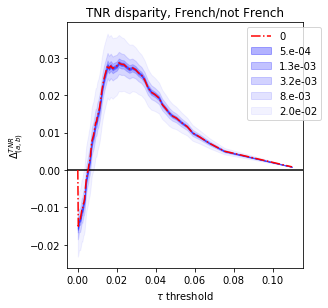

In [23]:
def plot_disp_over_reps(cate_pctiles, lowers, uppers, etas, A_names, disp_dir = 'TPR', shading = False ): 
    alphas = np.linspace(0.3,0.05, len(etas))
    plt.figure(figsize=(4,4));plt.axhline(0, color='black')
    plt.tight_layout()
    if shading: 
        [plt.fill_between( cate_pctiles, np.mean(lowers[:,i,:],axis=1), np.mean(uppers[:,i,:],axis=1), label=np.format_float_scientific(etas[i],precision=1), color = 'b', alpha = alphas[i] ) for i in range(len(etas))]
    else: 
        [plt.plot( cate_pctiles, np.mean(lowers[:,i,:],axis=1), label=np.format_float_scientific(etas[i],precision=1), color = 'b', alpha = alphas[i] ) for i in range(len(etas))]
        [plt.plot( cate_pctiles, np.mean(uppers[:,i,:],axis=1), label=np.format_float_scientific(etas[i],precision=1), color = 'r', alpha = alphas[i] ) for i in range(len(etas))]
    if (disp_dir == 'TPR'):
        plt.ylabel(r'$\Delta^{TPR}_{(a,b)}$')
    else: 
        plt.ylabel(r'$\Delta^{TNR}_{(a,b)}$')
    plt.xlabel(r'$\tau$ threshold')
    plt.title(disp_dir + ' disparity, '+A_names)


plt.figure()
plot_disp_over_reps(cate_pctiles, lowers, uppers, etas, 'French/not French', shading = True)
plt.plot(cate_pctiles,np.nanmean(disps_nom_tprs,axis=1),linestyle='-.',label = '0', color = 'r')
# plt.legend(bbox_to_anchor=(1.1,1))
plt.figure()
plot_disp_over_reps(cate_pctiles, tnr_lowers, tnr_uppers, etas, 'French/not French',disp_dir= 'TNR', shading = True )
plt.plot(cate_pctiles,np.nanmean(disps_nom_tnrs,axis=1),linestyle='-.',label = '0', color = 'r')
plt.legend(bbox_to_anchor=(1.1,1))





In [ ]:
def get_for_roc_from_sample( cate_pctiles, etas, A_, N_REPS, SAMPLE_FN, DATA_FN ): 
    indss = [ None ] * N_REPS
    cate_ests = [ None ] * N_REPS; cate_otherway = [ None ] * N_REPS
    n_perc = len(cate_pctiles)
    disps_nom_tprs = np.zeros([n_perc,N_REPS]); disps_nom_tnrs = np.zeros([n_perc,N_REPS]);
    lowers = np.zeros([n_perc, n_etas, N_REPS]); uppers = np.zeros([n_perc, n_etas, N_REPS])
    tnr_lowers = np.zeros([n_perc, n_etas, N_REPS]); tnr_uppers = np.zeros([n_perc, n_etas, N_REPS])

    for rep in range(N_REPS): 
        if rep % 10 == 0: 
            print rep
        indss[rep] = pd.read_csv(SAMPLE_FN+str(rep+1)+'.csv') - 1 # swap from R indexing ! 
        sample = np.zeros(len(A_)).astype(bool)
        sample[indss[rep]] = True
        # trained on [sample], oos preds on [-sample]
        cate_ests[rep] = np.clip(pd.read_csv(DATA_FN+str(rep+1)+'.csv').values,0,1).flatten()
#         if rep == 0: 
#             cate_pctiles = np.percentile(cate_ests[rep], np.linspace(0,100, n_perc))
        # trained on [-sample], oos preds on [sample]
        cate_otherway[rep] =  np.clip(pd.read_csv(DATA_FN+str(rep+1)+'.csv').values,0,1).flatten()

        # cate estimate is out of sample 
        [res_lower_, res_upper_] = get_disp_curve_over_etas(cate_ests[rep], n_perc, etas, A_[~sample], cate_ests[rep], 
              plotting=False, disparity = tpr_closed_form, parallel = "closed_form",
              fix_pctiles = True, fixed_pctiles = cate_pctiles)
        lowers[:,:,rep] = res_lower_; uppers[:,:,rep] = res_upper_ 

        [res_lower_tnr, res_upper_tnr] = get_disp_curve_over_etas(cate_ests[rep], n_perc, etas, A_[~sample], cate_ests[rep], 
          plotting=False, disparity = tnr_closed_form, parallel = "closed_form",
          fix_pctiles = True, fixed_pctiles = cate_pctiles)
        tnr_lowers[:,:,rep] = res_lower_tnr; tnr_uppers[:,:,rep] = res_upper_tnr 
        # get nominal tprs and tnrs 
        tprs_ = np.asarray([ tpr_estimation_delta((cate_ests[rep] >= cfpctile), cate_ests[rep], A_[~sample]) for cfpctile in cate_pctiles ]).reshape([len(cate_pctiles), 2])
        tnrs_ = np.asarray([ tnr_estimation_delta((cate_ests[rep] >= cfpctile), cate_ests[rep], A_[~sample]) for cfpctile in cate_pctiles ]).reshape([len(cate_pctiles), 2])
        disps_nom_tprs[:,rep] = tprs_[:,0] - tprs_[:,1]; disps_nom_tnrs[:,rep] = tnrs_[:,0] - tnrs_[:,1]
    return [ lowers, uppers, tnr_lowers, tnr_uppers, disps_nom_tprs, disps_nom_tnrs, cate_pctiles ]

cate_pctiles = np.percentile(np.clip(tau_hat,0,1), np.linspace(0,100, n_perc))



## iterate over classes

In [ ]:
samp = indss[0].values.flatten()
class_labels = [ ['not French', 'French'], ['not woman', 'woman'], ['>26yo','<26yo'] ]
for ind,A_ in enumerate(As): 
    plt.figure(figsize=(3,3))
    A_[samp]
    sns.kdeplot(cate_ests[0][A_[samp] == 0],label=class_labels[ind][0])
    sns.kdeplot(cate_ests[0][A_[samp] == 1],label=class_labels[ind][1])
    plt.xlim(0,max(cate_ests[0]))


[autoreload of fair_policies failed: Traceback (most recent call last):
  File "/Users/az/anaconda2/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "fair_policies.py", line 83
    else:
       ^
SyntaxError: invalid syntax
]


0
10
20
30
40
0
10
20
30
40
0
10
20
30
40


<Figure size 432x288 with 0 Axes>

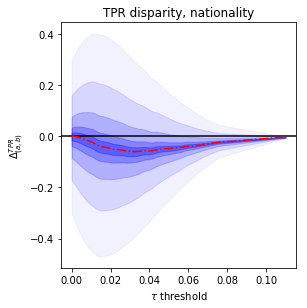

<Figure size 432x288 with 0 Axes>

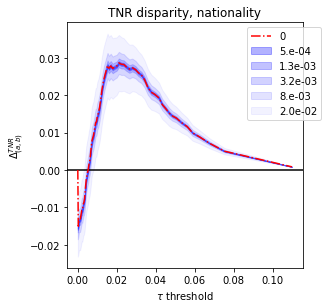

<Figure size 432x288 with 0 Axes>

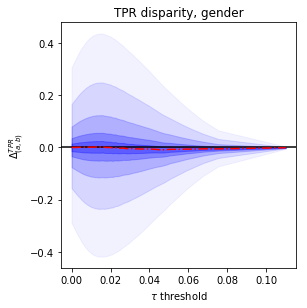

<Figure size 432x288 with 0 Axes>

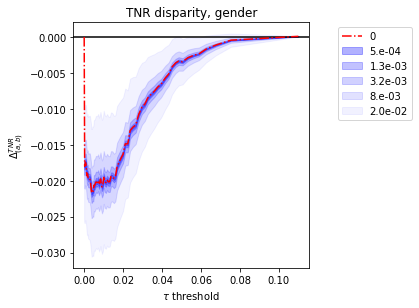

<Figure size 432x288 with 0 Axes>

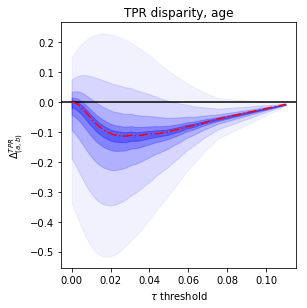

<Figure size 432x288 with 0 Axes>

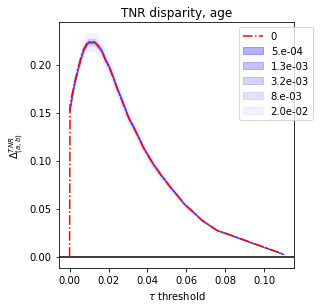

In [25]:
As = [A_french, A_woman, A_age]
A_titles = ['nationality', 'gender', 'age']
res = [None] * len(As)
for ind,A_ in enumerate(As): 
    [ lowers, uppers, tnr_lowers, tnr_uppers, disps_nom_tprs, disps_nom_tnrs, cate_pctiles ] = get_for_roc_from_sample( cate_pctiles, etas, A_, N_REPS, SAMPLE_FN, DATA_FN )
    res[ind] = [ lowers, uppers, tnr_lowers, tnr_uppers, disps_nom_tprs, disps_nom_tnrs, cate_pctiles ]
    plt.figure()
    plot_disp_over_reps(cate_pctiles, lowers, uppers, etas, A_titles[ind], shading = True )
    plt.plot(cate_pctiles[1:],np.nanmean(disps_nom_tprs,axis=1)[1:],linestyle='-.',label = '0', color = 'red')
    plt.savefig('tpr_disp_curve_' + A_titles[ind]+'.pdf',bbox_inches=None)
    # plt.legend(bbox_to_anchor=(1.1,1))
    plt.figure()
    plot_disp_over_reps(cate_pctiles, tnr_lowers, tnr_uppers, etas, A_titles[ind],disp_dir= 'TNR', shading = True )
    plt.plot(cate_pctiles[1:],np.nanmean(disps_nom_tnrs,axis=1)[1:],linestyle='-.',label = '0', color = 'red')
    plt.legend(bbox_to_anchor=(1.1,1))
    plt.savefig('tnr_disp_curve_' + A_titles[ind]+'.pdf',bbox_inches=None)



### Plot without recomputing

<Figure size 432x288 with 0 Axes>

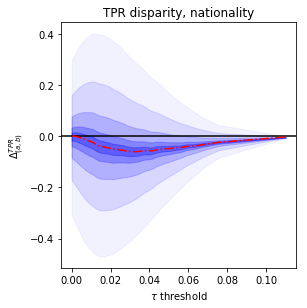

<Figure size 432x288 with 0 Axes>

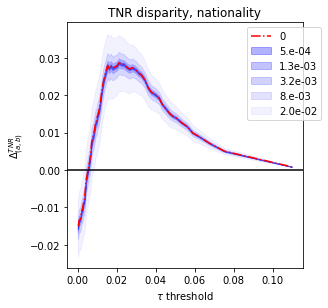

<Figure size 432x288 with 0 Axes>

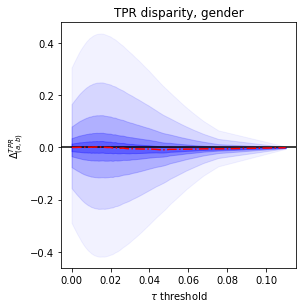

<Figure size 432x288 with 0 Axes>

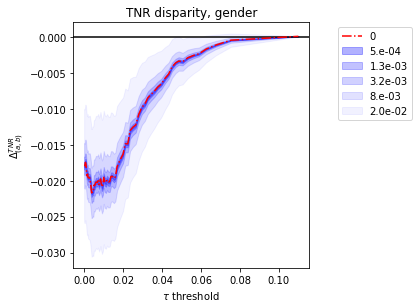

<Figure size 432x288 with 0 Axes>

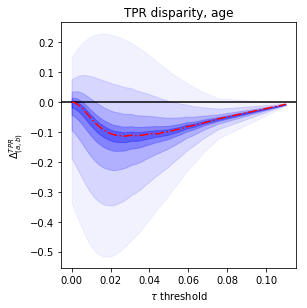

<Figure size 432x288 with 0 Axes>

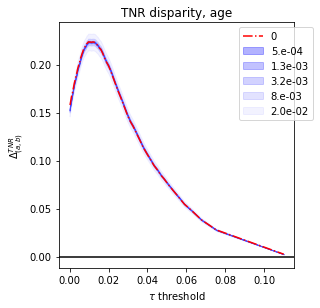

In [36]:
for ind,A_ in enumerate(As): 
    [ lowers, uppers, tnr_lowers, tnr_uppers, disps_nom_tprs, disps_nom_tnrs, cate_pctiles ] = res[ind] 
    plt.figure()
    plot_disp_over_reps(cate_pctiles, lowers, uppers, etas, A_titles[ind], shading = True )
    nonzeros = cate_pctiles!=0
    plt.plot(cate_pctiles[nonzeros],np.nanmean(disps_nom_tprs,axis=1)[nonzeros],linestyle='-.',label = '0', color = 'red')
    plt.savefig('tpr_disp_curve_' + A_titles[ind]+'.pdf',bbox_inches=None)
    # plt.legend(bbox_to_anchor=(1.1,1))
    plt.figure()
    plot_disp_over_reps(cate_pctiles, tnr_lowers, tnr_uppers, etas, A_titles[ind],disp_dir= 'TNR', shading = True )
    plt.plot(cate_pctiles[nonzeros],np.nanmean(disps_nom_tnrs,axis=1)[nonzeros],linestyle='-.',label = '0', color = 'red')
    plt.legend(bbox_to_anchor=(1.1,1))
    plt.savefig('tnr_disp_curve_' + A_titles[ind]+'.pdf',bbox_inches=None)



## Estimate an averaged ROC analysis

In [99]:
def get_roc_from_sample( cate_pctiles, etas, A_, N_REPS, SAMPLE_FN, DATA_FN ): 
    indss = [ None ] * N_REPS
    cate_ests = [ None ] * N_REPS; cate_otherway = [ None ] * N_REPS
    n_perc = len(cate_pctiles)
    disps_nom_tprs = np.zeros([n_perc,N_REPS]); disps_nom_tnrs = np.zeros([n_perc,N_REPS]);
    classes = [0,1]
    n_As = len(classes)
    tpr_lowers = np.zeros([n_perc, n_etas, N_REPS, n_As]); tpr_uppers = np.zeros([n_perc, n_etas, N_REPS, n_As])
    tnr_lowers = np.zeros([n_perc, n_etas, N_REPS, n_As]); tnr_uppers = np.zeros([n_perc, n_etas, N_REPS, n_As])
    for rep in range(N_REPS): 
        if rep % 10 == 0: 
            print rep
        indss[rep] = pd.read_csv(SAMPLE_FN+str(rep+1)+'.csv') - 1 # swap from R indexing ! 
        sample = np.zeros(len(A_)).astype(bool)
        sample[indss[rep]] = True
        # trained on [sample], oos preds on [-sample]
        cate_ests[rep] = np.clip(pd.read_csv(DATA_FN+str(rep+1)+'.csv').values,0,1).flatten()

        # get nominal tprs and tnrs 
        tprs_ = np.asarray([ tpr_estimation_delta((cate_ests[rep] >= cfpctile), cate_ests[rep], A_[~sample]) for cfpctile in cate_pctiles ]).reshape([len(cate_pctiles), 2])

        A_oos = (A[~sample]).astype(int)
        for ind_eta,eta in enumerate(etas): 
            for a in range(len(classes)): 
                tpr_uppers[:,ind_eta,rep,a] = np.asarray([tpr_closed_form_a((cate_ests[rep] >= cfpctile)[A_oos==a], cate_ests[rep][A_oos==a], eta*np.ones(sum(A_oos==a)), 'max') for cfpctile in cate_pctiles] )
                tpr_lowers[:,ind_eta,rep,a] = np.asarray([tpr_closed_form_a((cate_ests[rep] >= cfpctile)[A_oos==a], cate_ests[rep][A_oos==a], eta*np.ones(sum(A_oos==a)), 'min')for cfpctile in cate_pctiles])
                tnr_uppers[:,ind_eta,rep,a] = np.asarray([tnr_closed_form_a((cate_ests[rep] >= cfpctile)[A_oos==a], cate_ests[rep][A_oos==a], eta*np.ones(sum(A_oos==a)), 'max')for cfpctile in cate_pctiles])
                tnr_lowers[:,ind_eta,rep,a] = np.asarray([tnr_closed_form_a((cate_ests[rep] >= cfpctile)[A_oos==a], cate_ests[rep][A_oos==a], eta*np.ones(sum(A_oos==a)), 'min')for cfpctile in cate_pctiles])

    return [ tpr_uppers,tpr_lowers, tnr_uppers, tnr_lowers, cate_pctiles ]



In [146]:

def read_for_roc_parallel( cate_pctiles, etas, A_, rep, SAMPLE_FN, DATA_FN ): 
    n_perc = len(cate_pctiles)
    classes = [0,1]
    n_As = len(classes)
    tpr_lowers = np.zeros([n_perc, n_etas, n_As]); tpr_uppers = np.zeros([n_perc, n_etas, n_As])
    tnr_lowers = np.zeros([n_perc, n_etas, n_As]); tnr_uppers = np.zeros([n_perc, n_etas, n_As])

    indss = pd.read_csv(SAMPLE_FN+str(rep+1)+'.csv') - 1 # swap from R indexing ! 
    sample = np.zeros(len(A_)).astype(bool)
    sample[indss] = True
    # trained on [sample], oos preds on [-sample]
    cate_ests = np.clip(pd.read_csv(DATA_FN+str(rep+1)+'.csv').values,0,1).flatten()

    A_oos = (A_[~sample]).astype(int)
    for ind_eta,eta in enumerate(etas): 
        for a in range(len(classes)): 
            tpr_uppers[:,ind_eta,a] = np.asarray([tpr_closed_form_a((cate_ests >= cfpctile)[A_oos==a], cate_ests[A_oos==a], eta*np.ones(sum(A_oos==a)), 'max') for cfpctile in cate_pctiles] )
            tpr_lowers[:,ind_eta,a] = np.asarray([tpr_closed_form_a((cate_ests >= cfpctile)[A_oos==a], cate_ests[A_oos==a], eta*np.ones(sum(A_oos==a)), 'min')for cfpctile in cate_pctiles])
            tnr_uppers[:,ind_eta,a] = np.asarray([tnr_closed_form_a((cate_ests >= cfpctile)[A_oos==a], cate_ests[A_oos==a], eta*np.ones(sum(A_oos==a)), 'max')for cfpctile in cate_pctiles])
            tnr_lowers[:,ind_eta,a] = np.asarray([tnr_closed_form_a((cate_ests >= cfpctile)[A_oos==a], cate_ests[A_oos==a], eta*np.ones(sum(A_oos==a)), 'min')for cfpctile in cate_pctiles])
    return [tpr_uppers, tpr_lowers, tnr_uppers, tnr_lowers]


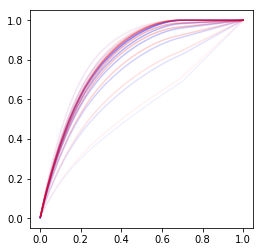

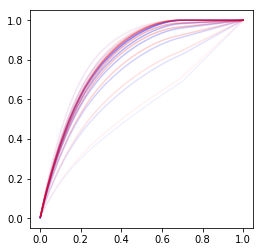

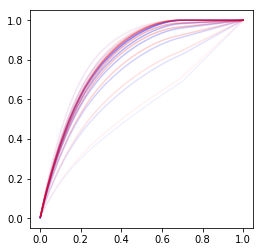

In [143]:
for i,A_ in enumerate(As):
    plot_roc_over_reps_frm_parallel(cate_pctiles, res_rocs_As[i], etas)

[1 0 0 ... 1 1 1]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=12)]: Done   2 tasks      | elapsed:  1.1min
[Parallel(n_jobs=12)]: Done   3 tasks      | elapsed:  1.2min
[Parallel(n_jobs=12)]: Done   4 tasks      | elapsed:  1.3min
[Parallel(n_jobs=12)]: Done   5 tasks      | elapsed:  1.3min
[Parallel(n_jobs=12)]: Done   6 tasks      | elapsed:  1.4min
[Parallel(n_jobs=12)]: Done   7 tasks      | elapsed:  1.5min
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done   9 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done  10 tasks      | elapsed:  1.7min
[Parallel(n_jobs=12)]: Done  11 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done  12 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done  13 tasks      | elapsed:  2.4min
[Parallel(n_jobs=12)]: Done  14 tasks      | elapsed:  2.4min
[Parallel(n_jobs=12)]: Done  15 tasks

<Figure size 432x288 with 0 Axes>

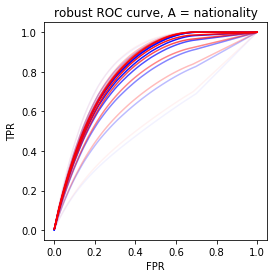

<Figure size 432x288 with 0 Axes>

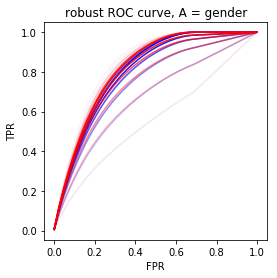

<Figure size 432x288 with 0 Axes>

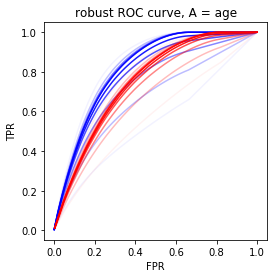

In [158]:


N_REPS = 50
res_rocs_As = [None] * len(As)
for ind,A_ in enumerate(As): 
    print A_
    res = Parallel(n_jobs=12,verbose = 50)(delayed(read_for_roc_parallel)( cate_pctiles, etas, A_, rep, SAMPLE_FN, DATA_FN) for rep in range(N_REPS))
    res_rocs_As[ind] = res
    pickle.dump(res, open('rocs_samp_'+A_titles[ind]+'.p','wb'))
    plt.figure()
    plot_roc_over_reps_frm_parallel(cate_pctiles, res, etas)
    plt.xlabel('FPR'); plt.ylabel('TPR')
    plt.title('robust ROC curve, A = '+A_titles[ind])
    plt.savefig('tpr_disp_curve_' + A_titles[ind]+'.pdf',bbox_inches=None)
    




0
1
0
1
0
1


<Figure size 432x288 with 0 Axes>

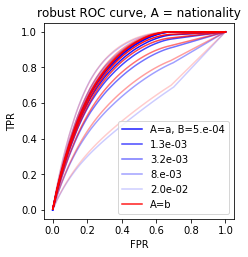

<Figure size 432x288 with 0 Axes>

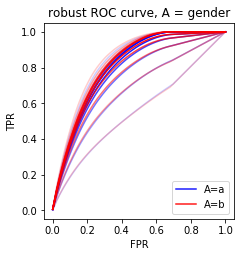

<Figure size 432x288 with 0 Axes>

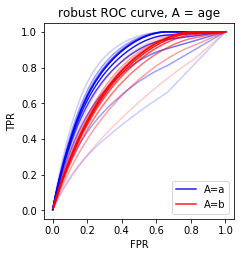

In [238]:
'''res obj contains
[tpr_uppers, tpr_lowers, tnr_uppers, tnr_lowers]
each of which is indexed as cate_pctiles, etas, a 
'''
def plot_roc_over_reps_frm_parallel(cate_pctiles, res, etas, label = False, xroc = False, class_labels=None):
    alphas = np.linspace(0.9,0.2, len(etas))
    plt.figure(figsize=(3.5,3.5));
    
    colors = ['b', 'r']
    tpr_uppers = np.stack( [res[ind][0] for ind in range(len(res))] )
    tpr_lowers = np.stack( [res[ind][1] for ind in range(len(res))] )
    tnr_uppers = np.stack( [res[ind][2] for ind in range(len(res))] )
    tnr_lowers = np.stack( [res[ind][3] for ind in range(len(res))] )
    classes = ['a', 'b']
    if xroc: 
        if label: 
#             r'$\tau_{b}^1 > \tau_{a}^0$'
            [plt.plot( 1-np.mean(tnr_lowers[:,:,i,0],axis=0), np.mean(tpr_lowers[:,:,i,1],axis=0),  label= (str() if i!=0 else 'Resp. '+class_labels[1]+' > \n non-R. '+class_labels[0]), color = colors[1], alpha = alphas[i] ) for i in range(len(etas))]
            [plt.plot( 1-np.mean(tnr_uppers[:,:,i,0],axis=0), np.mean(tpr_uppers[:,:,i,1],axis=0),  color = colors[1], alpha = alphas[i] ) for i in range(len(etas))]
             #r'$\tau_{a}^1 > \tau_{b}^0$'
            [plt.plot( 1-np.mean(tnr_uppers[:,:,i,1],axis=0), np.mean(tpr_uppers[:,:,i,0],axis=0), label= (str() if i!=0 else 'Resp. '+class_labels[0]+' > \n non-R. '+class_labels[1]), color = colors[0], alpha = alphas[i] ) for i in range(len(etas))]
            [plt.plot( 1-np.mean(tnr_lowers[:,:,i,1],axis=0), np.mean(tpr_lowers[:,:,i,0],axis=0), color = colors[0], alpha = alphas[i] ) for i in range(len(etas))]


        else:
            [plt.plot( 1-np.mean(tnr_lowers[:,:,i,0],axis=0), np.mean(tpr_lowers[:,:,i,1],axis=0), label= (str() if i!=0 else 'Resp. '+class_labels[1]+' > \n non-R. '+class_labels[0]), color = colors[1], alpha = alphas[i] ) for i in range(len(etas))]
            [plt.plot( 1-np.mean(tnr_uppers[:,:,i,0],axis=0), np.mean(tpr_uppers[:,:,i,1],axis=0), color = colors[1], alpha = alphas[i] ) for i in range(len(etas))]
            [plt.plot( 1-np.mean(tnr_uppers[:,:,i,1],axis=0), np.mean(tpr_uppers[:,:,i,0],axis=0), label= (str() if i!=0 else 'Resp. '+class_labels[0]+' > \n non-R. '+class_labels[1]), color = colors[0], alpha = alphas[i] ) for i in range(len(etas))]
            [plt.plot( 1-np.mean(tnr_lowers[:,:,i,1],axis=0), np.mean(tpr_lowers[:,:,i,0],axis=0), color = colors[0], alpha = alphas[i] ) for i in range(len(etas))]

    else: 
        for a in range(len(colors)): 
            print a 
            if (label)&(a==0):
                [plt.plot( 1-np.mean(tnr_lowers[:,:,i,a],axis=0), np.mean(tpr_lowers[:,:,i,a],axis=0),  label= (str() if i!=0 else 'A=' + str(classes[a]) + ', B=') + str(np.format_float_scientific(etas[i],precision=1)), color = colors[a], alpha = alphas[i] ) for i in range(len(etas))]
            else:
                [plt.plot( 1-np.mean(tnr_lowers[:,:,i,a],axis=0), np.mean(tpr_lowers[:,:,i,a],axis=0), label= (str() if i!=0 else 'A=' + str(classes[a])), color = colors[a], alpha = alphas[i] ) for i in range(len(etas))]
            [plt.plot( 1-np.mean(tnr_uppers[:,:,i,a],axis=0), np.mean(tpr_uppers[:,:,i,a],axis=0), color = colors[a], alpha = alphas[i] ) for i in range(len(etas))]
    plt.xlabel('FPR')
    plt.ylabel('TPR')

for ind,A_ in enumerate(As): 
    res = pickle.load(open('rocs_samp_'+A_titles[ind]+'.p','rb'))
    plt.figure()
    plt.tight_layout()
    if ind == 0: 
        plot_roc_over_reps_frm_parallel(cate_pctiles, res, etas, label = True)
    else: 
        plot_roc_over_reps_frm_parallel(cate_pctiles, res, etas)
    plt.legend()
    plt.tight_layout()
    plt.title('robust ROC curve, A = '+A_titles[ind])
    plt.savefig('roc-' + A_titles[ind]+'-smoothed.pdf',bbox_inches=None)




<Figure size 432x288 with 0 Axes>

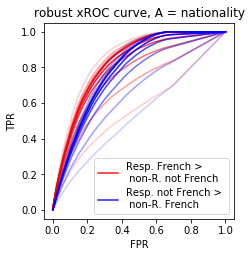

<Figure size 432x288 with 0 Axes>

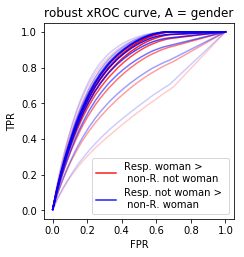

<Figure size 432x288 with 0 Axes>

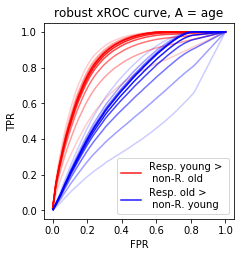

In [239]:
class_labels_ = [['not French', 'French',], ['not woman', 'woman'], ['old','young']]


for ind,A_ in enumerate(As): 
    res = pickle.load(open('rocs_samp_'+A_titles[ind]+'.p','rb'))
    plt.figure()
    if ind == 0: 
        plot_roc_over_reps_frm_parallel(cate_pctiles, res, etas, label = True, xroc = True, class_labels=class_labels_[ind])
    else: 
        plot_roc_over_reps_frm_parallel(cate_pctiles, res, etas, xroc = True, class_labels=class_labels_[ind])
    plt.legend()
    plt.tight_layout()
    plt.title('robust xROC curve, A = '+A_titles[ind])
    plt.savefig('xroc-' + A_titles[ind]+'-smoothed.pdf',bbox_inches=None)
    

In [ ]:
res_roc = [None] * len(As)

for ind,A_ in enumerate(As): 
    [ tpr_uppers,tpr_lowers, tnr_uppers, tnr_lowers, cate_pctiles ] = get_roc_from_sample( cate_pctiles, etas, A_, N_REPS, SAMPLE_FN, DATA_FN )
    res_roc[ind] = [ lowers, uppers, tnr_lowers, tnr_uppers, disps_nom_tprs, disps_nom_tnrs, cate_pctiles ]
    plt.figure()
    plot_disp_over_reps(cate_pctiles, lowers, uppers, etas, A_titles[ind], shading = True )
    plt.plot(cate_pctiles[1:],np.nanmean(disps_nom_tprs,axis=1)[1:],linestyle='-.',label = '0', color = 'red')
    plt.savefig('tpr_disp_curve_' + A_titles[ind]+'.pdf',bbox_inches=None)
    # plt.legend(bbox_to_anchor=(1.1,1))
    plt.figure()
    plot_disp_over_reps(cate_pctiles, tnr_lowers, tnr_uppers, etas, A_titles[ind],disp_dir= 'TNR', shading = True )
    plt.plot(cate_pctiles[1:],np.nanmean(disps_nom_tnrs,axis=1)[1:],linestyle='-.',label = '0', color = 'red')
    plt.legend(bbox_to_anchor=(1.1,1))
    plt.savefig('tnr_disp_curve_' + A_titles[ind]+'.pdf',bbox_inches=None)

